# Feature Engineering - Comparison beetween Manual and Automated feature creation.

## Introduction

What are features? Feature can be descried as a characteristic or a set of caracteristics. These characteristics can be presented in a measurable form. When the do so, they can be called features.
When we now what features are we can procceed to feature engineering. Ffeature engineering is a process of creating new features out of already existing features in a dataset.
Overall performance of our predictive model depends heavily on quality of the features in datase which is used to train thath model. The general idea is to create enough new features which help in providing more information.

We are going to use Featuretools for the task. It is an open source library for performing automated feature engineering. It is maninly used for the feature generation process, giving user more time to focus on other aspects of machine learning model building.

Featuretools uses three major compontents for automated feature engineering process:

- Entities - An Entity can be considered as a representation of a Pandas DataFrame. A collection of multiple entities is called an Entityset.
- Entitysets - collection of tables and the relationships between entities. It is just another Python data structure, with its own methods and attributes.
- Deep Feature Synthesis (DFS) - stacks multiple transformation and aggregation operations (which are 	called feature primitives in the vocab of featuretools) to create features from data spread across many tables. The depth of a deep feature is the number of primitives required to make the feature.
- Feature primitives - are the building blocks of Featuretools. They define individual computations 	that can be applied to raw datasets to create new features. Because a primitive only constrains the input and output data types, they can be applied across datasets and can stack to create new calculations.
- Transformation - creating new features from the table columns
- Aggegation - creating new features from realted dataset and adding them to already existing dataset. 

In the next paragraph we are going to determine our task.


## Task: Predicting Life of an Engine using NASA aquired data.

The main idea of the project is to predict engine failure. It can be done by trying to predict engine operational cycles. These cycles are tend to fail the longer machine is operating. We can predict the number of cycles since the specified time moment to the moment of failure of the machine(which is the last cycle during the angine will work.


We will try to compare three models to solve this problem. First one will be manual creation of the features. The second will be automated process by using Featuretools library. Data used in this project will be dowloaded from NASA datasets https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

#### Data description: 
Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

"Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.


The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.


The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

-  unit number
-  time, in cycles
-  operational setting 1
-  operational setting 2
-  operational setting 3
-  sensor measurement  1
-  sensor measurement  2

...
-  sensor measurement  26"

#### Analysis aproach:

Predicting Remaining Useful Life with Manual Feature Engineering¶
In this notebook, we will work with NASA provided data to accomplish a critical real-world task: predict the remaining useful life of an engine. Our first attempt will be to tackle this problem by hand, building features based on aggregations, domain knowledge (if applicable), and time-series based methods. The original data can be downloaded here

Manual Feature Engineering:

-  Specify the prediction problem - Step 4
-  For each engine, define the cutoff point and label - Step 5-6
-  Subset data to before cutoff point for each engine - Step 7-9
-  Establish a baseline performance measure - Step 10 
-  Perform basic aggregations for each engine to develop features - Step 11 - 12
-  Evaluate performance - Steps 13-15
-  Use feature selection to reduce the number of features - Step 16
-  Evaluate performance again - Step 17
-  Try more sophisticated feature engineering - Step 18
-  Time-series analysis - Step 19-20
-  Evaluate performance - Step 21
-  KMeans clustering - Steps 22-23
-  Time Series Operations using tsfresh - Step 24
-  Evaluate performance of new features - Step 25
-  Random Search and Evaluation - Steps 26-27
-  Conclusion - Step 29

Automatic Feature Engineering:

-  Perform random search to tune the random forest model


#### Step 1 -  Libraries import

First, we import necessary libriaries for our model.

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


from utils import plot_feature_importances, feature_selection #additional file for defining our own fuctions.

#### Step 2 - Dispalying our data

In [21]:
# First look on our data, straight from the file.
inputdata = pd.read_csv('train_FD002.txt', sep=' ', header=-1,)
inputdata.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,NaN,NaN
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,NaN,NaN
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,NaN,NaN
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,NaN,NaN
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,NaN,NaN


Comparing to the one above we have, we have to add headers for our columns. 

The data columns should have look like the ones presented below:

-  unit number
-  time, in cycles
-  operational setting 1
-  operational setting 2
-  operational setting 3
-  sensor measurement  1
-  sensor measurement  2

...
-  sensor measurement  26"

#### Step 3 - adding column names

In [22]:
# Operational settings columns: 1, 2,3 
operational_settings = ['operational_setting_{}'.format(i + 1) for i in range (3)]

# Sensor columns from 1 to 26
sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(26)]

# All columns
cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns
data = pd.read_csv('train_FD002.txt', sep=' ', header=-1, names=cols)
data.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,334,2223,100.00,14.73,8.8071,NaN,NaN,NaN,NaN,NaN
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,330,2212,100.00,10.41,6.2665,NaN,NaN,NaN,NaN,NaN
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,309,1915,84.93,14.08,8.6723,NaN,NaN,NaN,NaN,NaN
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,329,2212,100.00,10.59,6.4701,NaN,NaN,NaN,NaN,NaN
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,309,1915,84.93,14.13,8.5286,NaN,NaN,NaN,NaN,NaN


## Prediction Problem

#### Step 4 - Prediction problem analysis

We have to figure out our prediction problem. From what we have we know we have the whole history of the engine operation cycles together with the last successful measurement just before failure. 
Therefore, we have to come up with our own prediction problem which we do as follows:
-  We create random starting date which will be january 1, 2010 just to create cycles timeline. We will add a time column based of our time in cycle column ( we presume the on cycle takes 10 minutes).
-  We create randomized cutoff points for each engine by selecting a random time.
-  We create the label which describe time between the cutoff point and the end of life of the engine(finding the number of cycles)
-  subset the data for each engine for the time before the prediction point

At the end of this process, we will have a labeled training set where each row is one engine and the label is the number of cycles to failure from that point (the prediction_point also called the cutoff_time) in time. We can then use the past operating data from before the prediction point and the labels to train a machine learning model.

In [23]:
# Setting randomized start date.
starting_date = pd.Timestamp(2010, 1, 1)

# Creating additional time column which will be presented as the time in cycles(10 minutes per cycle).
data['time'] = [starting_date + pd.Timedelta(x * 10, 'm') for x in data['time_in_cycles']]

data[['engine_no', 'time_in_cycles', 'time']].head()

,engine_no,time_in_cycles,time
0,1,1,2010-01-01 00:10:00
1,1,2,2010-01-01 00:20:00
2,1,3,2010-01-01 00:30:00
3,1,4,2010-01-01 00:40:00
4,1,5,2010-01-01 00:50:00


In [24]:
data.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26,time
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2223,100.00,14.73,8.8071,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:10:00
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2212,100.00,10.41,6.2665,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:20:00
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,1915,84.93,14.08,8.6723,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:30:00
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2212,100.00,10.59,6.4701,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:40:00
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,1915,84.93,14.13,8.5286,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:50:00



***

#### Step 5 - Adding prediction point

For each engine, we need to create a random time moment to be a prediction point. We will enforce the limits that we need to have at least 10 measurements before our created prediction point. It is made to avoid the situations of having not enough data for train.

In [36]:
np.random.seed(50)

# Dataframe to hold results
engines = pd.DataFrame(columns = ['engine_no', 'prediction_point', 'label']) # creating df with eng.., pred, label columns
engine_list = data['engine_no'].unique() # taking uniqe values from engine from data to create engine_list

# Iterate through each engine
for engine in engine_list:
    
    # Subset to the engine
    subset = data[data['engine_no'] == engine].copy().sort_values('time')
    
    measurements = subset.shape[0] # measurements = rows of subsets
    
    # Select a random index for the prediction point
    random_index = np.random.randint(10, measurements - 1) # Return random integers from 10(our limit - inclusive) to measurements(rows- exclusive).
    
    # Record the predictino point and the label which is the remaining number of cycles
    prediction_point = subset.iloc[random_index, :].copy()['time'] # iloc gets rows (or columns) at particular positions in the index (so it only takes integers).
    label = measurements - random_index # creating prediction label. Measurements(Rows) - random point in rows
    
    # Record the measurements
    engines = engines.append(pd.DataFrame({'engine_no': engine, 'prediction_point': prediction_point, 
                                           'label': label}, index = [0]), 
                             ignore_index = True, sort = True)

***
#### Step 6 - Saving The Prediction

In [26]:
# Saving the prediction problem 
engines.to_csv('..engines_4.csv', index = False)
engines.head()

,engine_no,label,prediction_point
0,1,30,2010-01-01 20:00:00
1,2,127,2010-01-01 23:50:00
2,3,126,2010-01-01 13:30:00
3,4,155,2010-01-01 13:30:00
4,5,122,2010-01-01 05:30:00


***
#### Step 7 -  Limit Data to before prediction point

For each engine data from before the prediction point can be used to predict failure. We have to subset the data table for each engine until only times before the prediction point. In Futuretools we will call that point cutoff_time. 

In [40]:
legal_data = pd.DataFrame(columns = data.columns) # copying columns from data set

In [41]:
for i, engine in engines.iterrows():
    # Subset to times before the prediction point. Time before the prediction point for specific engine
    legal_data_subset = data[(data['time'] < engine['prediction_point']) & (data['engine_no'] == engine['engine_no'])].copy()
    
    legal_data = legal_data.append(legal_data_subset, ignore_index = True, sort = True) # adding rows to subset

In [42]:
train_obs = legal_data.copy() # Creating train subset
train_obs.to_csv('..train_obs.csv', index = False)
train_obs.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time,time_in_cycles
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,2010-01-01 00:10:00,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2010-01-01 00:20:00,2
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,2010-01-01 00:30:00,3
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,2010-01-01 00:40:00,4
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,2010-01-01 00:50:00,5


***
#### Step 8 - Naive baseline. Establishing the way of measuring the performance. Average_guess and half_life_guess

To measure a perfomrance(to judge how well our model works) we are going to use Mean Absolute Percentage Error (MAPE). This is the average of the absolute value of (prediction - true value) / true value) and is expressed as a percentage.

For the naive baseline, we can use two methods:

-Guess the average value of the "label" in the training data for all instances on the testing set - average_guess.

-For each engine in the testing data, predict it has reached half its life at the end of the data and will continue to operate for however many cycles it has already operated - half_life_guess.

First we need to read into the testing data which is the same format as the training data.

***
#### Step 9 - Preparing test_data

In [45]:
test_obs = pd.read_csv('test_FD002.txt', sep=' ', header=-1, names=cols)

test_obs.head() # We are missing "time" column.

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,369,2319,100.00,28.42,17.1551,NaN,NaN,NaN,NaN,NaN
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,364,2324,100.00,24.29,14.8039,NaN,NaN,NaN,NaN,NaN
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,333,2223,100.00,14.98,8.9125,NaN,NaN,NaN,NaN,NaN
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,332,2212,100.00,10.35,6.4181,NaN,NaN,NaN,NaN,NaN
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,305,1915,84.93,14.31,8.5740,NaN,NaN,NaN,NaN,NaN


In [46]:
# Pick a starting date (this can be arbitrary)
starting_date = pd.Timestamp(2010, 1, 1)

# Create a time column using the time in cycles * 10 minutes per cycle
test_obs['time'] = [starting_date + pd.Timedelta(x * 10, 'm') for x in test_obs['time_in_cycles']]

test_obs.to_csv('test_obs.csv', index = False)
test_obs.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26,time
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2319,100.00,28.42,17.1551,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:10:00
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2324,100.00,24.29,14.8039,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:20:00
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2223,100.00,14.98,8.9125,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:30:00
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2212,100.00,10.35,6.4181,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:40:00
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,1915,84.93,14.31,8.5740,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:50:00



*** 

#### Step 10 - half_life_guess and average_guess calculations.

In [47]:
# Half life guess
train_half_life_guess = train_obs.groupby('engine_no').apply(lambda x: 2 * x.shape[0])

# Dataframe with both baselines
train_baseline = pd.DataFrame({'engine_no': train_obs['engine_no'].unique(), 
                               'half_life_guess': train_half_life_guess.values,
                               'average_guess': engines['label'].mean()})

In [48]:
# Make two baseline guesses
test_half_life_guess = test_obs.groupby('engine_no').apply(lambda x: 2 * x.shape[0])
test_baseline = pd.DataFrame({'engine_no': test_obs['engine_no'].unique(), 
                              'half_life_guess': test_half_life_guess.values,
                               'average_guess': engines['label'].mean()})

The labels for the testing data are in a separate file that we can read in.

In [49]:
test_y = pd.read_csv('RUL_FD002.txt', sep=' ', header=-1, names=['label'], index_col=False)
test_y.head()

,label
0,18
1,79
2,106
3,110
4,15


We'll write a basic function to calculate the mean absolute percentage error and then apply it to the two baselines.


****

#### Step 11 - Calculating MAPE for average guess and half_life_guess


In [50]:
# defining mape function

def mape(y_true, pred):
    mape = 100 * np.mean(abs(y_true - pred) / y_true)
    
    return mape

In [51]:
print('The average_guess train MAPE is: {:.2f}.'.format(mape(engines['label'], train_baseline['average_guess'])))
print("The average_guess  test MAPE is: {:.2f}.".format(mape(test_y['label'], test_baseline['average_guess'])))

The average_guess train MAPE is: 158.89.
The average_guess  test MAPE is: 226.44.


In [52]:
print('The half_life train MAPE is: {:.2f}.'.format(mape(engines['label'], train_baseline['half_life_guess'])))
print('The half_life  test MAPE is: {:.2f}.'.format(mape(test_y['label'], test_baseline['half_life_guess'])))

The half_life train MAPE is: 614.89.
The half_life  test MAPE is: 926.51.


These baselines give us a target for our machine learning models. 

#### Step 11 -  Approach to Manual Feature Engineering

The train_obs is now a child table of engines because for each unique engine (identified by the engine_no), there are multiple rows in the train_obs. Our final train dataframe will need to have one unique row for every engine, with the features in the columns, so feature engineering will involve aggregating the train_obs for every engine. The same operations that are done to train_obs will have to be applied to test_obs as well because we need to have the same columns in both the training and testing set.

In [53]:
train_obs = train_obs.drop(columns = 'time') # getting rid of time column.
train_obs.shape
train_obs.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_25,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time_in_cycles
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,NaN,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,NaN,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,3
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,NaN,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,4
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,NaN,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,5


***
#### Step 12 - Manual Aggregations

We can perform numerical aggregations of every column in train_obs table. If we have no idea what the columns represent, it will provide a thorough summary of every column.

In [54]:
# Dealing with some type issues. Copy of the array, cast to a specified type.
train_obs['sensor_measurement_17'] = train_obs['sensor_measurement_17'].astype(np.float32)
train_obs['sensor_measurement_18'] = train_obs['sensor_measurement_18'].astype(np.float32)
train_obs['time_in_cycles'] = train_obs['time_in_cycles'].astype(np.int32)

# Aggregate each column
train_agg = train_obs.groupby('engine_no').agg(['min', 'max', 'mean', 'sum', 'std'])
train_agg.head()

operational_setting_1                                            \
                            min      max       mean        sum        std   
engine_no                                                                   
1                        0.0000  42.0077  25.414484  3024.3236  15.300117   
2                        0.0000  42.0076  23.734917  3370.3582  14.711035   
3                        0.0002  42.0073  25.365650  2029.2520  13.972098   
4                        0.0004  42.0075  23.640294  1891.2235  15.508015   
5                        0.0008  42.0071  21.721191   695.0781  14.481060   

          operational_setting_2                                       \
                            min     max      mean      sum       std   
engine_no                                                              
1                           0.0  0.8419  0.590210  70.2350  0.315502   
2                           0.0  0.8420  0.571921  81.2128  0.310070   
3                           0.0  0.8420  0.600951  48.0761  0.282966   
4                           0.0  0.8415  0.563961  45.1169  0.323623   
5                           0.0  0.8417  0.528438  16.9100  0.319769   

             ...     sensor_measurement_9                                    \
             ...                      min      max         mean         sum   
engine_no    ...                                                              
1            ...                  7993.23  9051.13  8475.882857  1008630.06   
2            ...                  8005.94  9074.03  8525.690704  1210648.08   
3            ...                  8007.77  9060.51  8496.240750   679699.26   
4            ...                  8004.46  9061.68  8562.626375   685010.11   
5            ...                  8009.47  9066.37  8548.107500   273539.44   

                      time_in_cycles                               
                  std            min  max  mean    sum        std  
engine_no                                                          
1          344.834682              1  119  60.0   7140  34.496377  
2          347.059747              1  142  71.5  10153  41.135953  
3          305.517658              1   80  40.5   3240  23.237900  
4          328.079571              1   80  40.5   3240  23.237900  
5          347.725391              1   32  16.5    528   9.380832  

[5 rows x 150 columns]

In order to better keep track of the columns, we rename them using a for loop with the original column and then the statistic.

In [55]:
new_cols = []

# Iterate through the columns and create new names
for col in train_agg.columns.levels[0]:
    for stat in train_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
train_agg.columns = new_cols
train_agg.head()


,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,sensor_measurement_9-min,sensor_measurement_9-max,sensor_measurement_9-mean,sensor_measurement_9-sum,sensor_measurement_9-std,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,7993.23,9051.13,8475.882857,1008630.06,344.834682,1,119,60.0,7140,34.496377
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,8005.94,9074.03,8525.690704,1210648.08,347.059747,1,142,71.5,10153,41.135953
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,8007.77,9060.51,8496.240750,679699.26,305.517658,1,80,40.5,3240,23.237900
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,8004.46,9061.68,8562.626375,685010.11,328.079571,1,80,40.5,3240,23.237900
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,8009.47,9066.37,8548.107500,273539.44,347.725391,1,32,16.5,528,9.380832


The code above gave us around  150 features that we can use as a main training dataframe.

#### Step 13 - Assess Performance

We need to apply the same operation to the testing data as we did to train model.We do that to asses the performance of our model.

In [56]:
# Apply same operations to testing data
test_agg = test_obs.groupby('engine_no').agg(['min', 'max', 'mean', 'sum', 'std'])

new_cols = []

for col in test_agg.columns.levels[0]:
    for stat in test_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
test_agg.columns = new_cols
test_agg.head()

,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,...,sensor_measurement_25-min,sensor_measurement_25-max,sensor_measurement_25-mean,sensor_measurement_25-sum,sensor_measurement_25-std,sensor_measurement_26-min,sensor_measurement_26-max,sensor_measurement_26-mean,sensor_measurement_26-sum,sensor_measurement_26-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,1,258,129.5,33411,74.622383,0.0002,42.0078,24.157602,6232.6614,14.625359,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2,1,55,28.0,1540,16.020820,0.0005,42.0079,26.512127,1458.1670,15.193411,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
3,1,165,83.0,13695,47.775517,0.0001,42.0078,22.663222,3739.4316,15.144796,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4,1,86,43.5,3741,24.969982,0.0002,42.0078,24.061074,2069.2524,14.675946,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
5,1,148,74.5,11026,42.868014,0.0000,42.0074,23.739297,3513.4160,14.189404,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN



***

#### Step 14 - Modeling, RandomForest

We will use Random Forest algorithm implemented in Scikit-Learn. Performance will be assessed by MAPE using 5 fold CV on both training and test data.

In [61]:
mape_scorer = make_scorer(mape, greater_is_better = False)

def evaluate(train, train_labels, test, test_labels):
    """Evaluate a training dataset in cross validation and on the test data"""
    
    # Use the same model for each training set for now
    model = RandomForestRegressor(n_estimators = 100, 
                                  random_state = 50, 
                                  n_jobs = -1)
    
    train = train.replace({np.inf: np.nan})
    test = test.replace({np.inf: np.nan})
    
    feature_names = list(train.columns)
    
    # Impute the missing values by median
    imputer = Imputer(strategy = 'median', axis = 1)
    train = imputer.fit_transform(train)
    test = imputer.transform(test)
    
    # Fit on the training data and make predictions
    model.fit(train, train_labels)
    preds = model.predict(test)
    
    cv_score = -1 * cross_val_score(model, train, train_labels, 
                                    scoring = mape_scorer, cv = 3)
    
    # Calculate the performance
    mape_score = mape(test_labels, preds)
    print('5-fold CV MAPE: {:.2f} with std: {:.2f}'.format(cv_score.mean(), cv_score.std()))
    print('The Random Forest test MAPE: {:.2f}.'.format(mape_score))
    
    # Record feature importances
    feature_importances = pd.DataFrame({'feature': feature_names, 
                                        'importance': model.feature_importances_})
    
    return preds, feature_importances

In [62]:
# Remove the engine number since it should not be predictive
train = train_agg.reset_index(drop = True)
test = test_agg.reset_index(drop = True)

train_labels = engines['label']
test_labels = test_y['label']

preds, fi = evaluate(train, train_labels, test, test_labels)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


5-fold CV MAPE: 47.38 with std: 3.26
The Random Forest test MAPE: 232.47.


***
#### Step 15 - Analysing first results

We received MAPE even worse than our guess score which was:
-  The average_guess train MAPE is: 158.89.
-  The average_guess  test MAPE is: 226.44.
-  The Random Forest test MAPE: 232.47.

We're probably severaly overfitting to the training data given the much lower cross validation error than testing error. 
To get a sense of what might be wrong, we can plot the predictions.

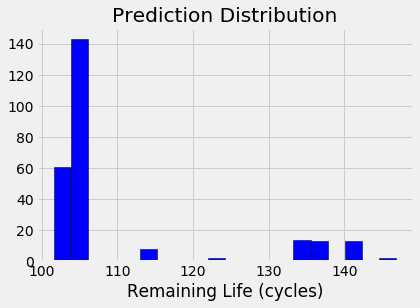

In [65]:
plt.style.use('fivethirtyeight')

plt.hist(preds, bins = 20, color = 'blue', edgecolor = 'k')
plt.title('Prediction Distribution'); 
plt.xlabel('Remaining Life (cycles)');


We can also plot the 10 most important features to see what the model thinks are the most relevant features we made.

,feature,importance,importance_normalized,cumulative_importance
0,operational_setting_2-sum,0.214550,0.214550,0.214550
1,operational_setting_1-sum,0.090473,0.090473,0.305023
2,sensor_measurement_4-max,0.079222,0.079222,0.384245
3,sensor_measurement_16-sum,0.042174,0.042174,0.426419
4,sensor_measurement_15-sum,0.041890,0.041890,0.468308
5,sensor_measurement_12-sum,0.032634,0.032634,0.500942
6,sensor_measurement_11-max,0.031334,0.031334,0.532275
7,sensor_measurement_8-max,0.029826,0.029826,0.562102
8,sensor_measurement_15-max,0.021419,0.021419,0.583521
9,sensor_measurement_3-max,0.018774,0.018774,0.602295


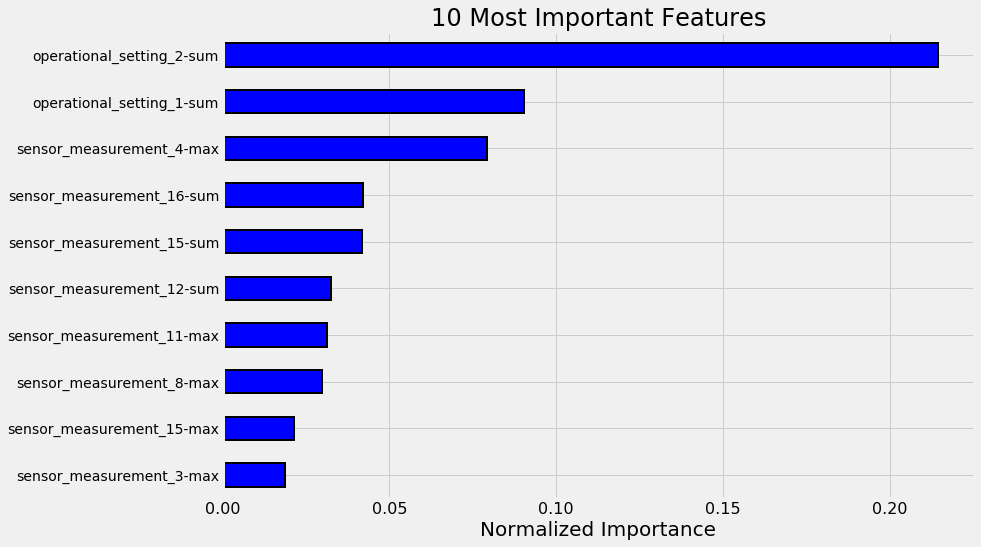

In [66]:
norm_fi = plot_feature_importances(fi, 10) # feature Importance written in the utility file
norm_fi.head(10)

A lot of different values were very smilar fo all angines. It ay be because we did not proceed with the feature selection.

***

#### Step 16 - Feature selection

Because some irrelevant features can slow down the model, now we will remove some of them. That process should lead to a better model performance.

 Below, we apply four methods of feature selection to the dataset and then re-evaluate. 
 
 Feature selection here is composed of:

-  Remove columns with more than 90% missing values
-  Remove columns with only a single unique value
-  Remove one of each pair of columns with a correlation greater than 0.95.
-  Removing some of the features can help the model generalize to the testing data.

In [67]:
def feature_selection(feature_matrix, missing_threshold=90, correlation_threshold=0.95):
    """Feature selection for a dataframe."""
    
    feature_matrix = pd.get_dummies(feature_matrix)
    n_features_start = feature_matrix.shape[1]
    print('Original shape: ', feature_matrix.shape)

    # Find missing and percentage
    missing = pd.DataFrame(feature_matrix.isnull().sum())
    missing['percent'] = 100 * (missing[0] / feature_matrix.shape[0])
    missing.sort_values('percent', ascending = False, inplace = True)

    # Missing above threshold
    missing_cols = list(missing[missing['percent'] > missing_threshold].index)
    n_missing_cols = len(missing_cols)

    # Remove missing columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in missing_cols]]
    print('{} missing columns with threshold: {}.'.format(n_missing_cols,
                                                                        missing_threshold))
    
    # Zero variance
    unique_counts = pd.DataFrame(feature_matrix.nunique()).sort_values(0, ascending = True)
    zero_variance_cols = list(unique_counts[unique_counts[0] == 1].index)
    n_zero_variance_cols = len(zero_variance_cols)

    # Remove zero variance columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in zero_variance_cols]]
    print('{} zero variance columns.'.format(n_zero_variance_cols))
    
    # Correlations
    corr_matrix = feature_matrix.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    n_collinear = len(to_drop)
    
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]
    print('{} collinear columns removed with threshold: {}.'.format(n_collinear,
                                                                          correlation_threshold))
    
    total_removed = n_missing_cols + n_zero_variance_cols + n_collinear
    
    print('Total columns removed: ', total_removed)
    print('Shape after feature selection: {}.'.format(feature_matrix.shape))
    return feature_matrix

In [68]:

train_fs = feature_selection(train)
test_fs = test[train_fs.columns]

Original shape:  (260, 150)
20 missing columns with threshold: 90.
15 zero variance columns.
72 collinear columns removed with threshold: 0.95.
Total columns removed:  107
Shape after feature selection: (260, 43).


***
We removed 107 columns. and reshape the dataset(from 260, 150 to 260, 43).

Now we predict again on our train_fs and test_fs data.

#### Step 17 - Calculating model again

In [70]:
preds, fi = evaluate(train_fs, train_labels, test_fs, test_labels)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


5-fold CV MAPE: 48.40 with std: 5.37
The Random Forest test MAPE: 51.27.


The performance increased to MAPE 51.27 from 232.47 after data cleaning. It is above our baseline on both: cross validation and on the training data.

Below we show the prediction distribution and 10 most Important Features.

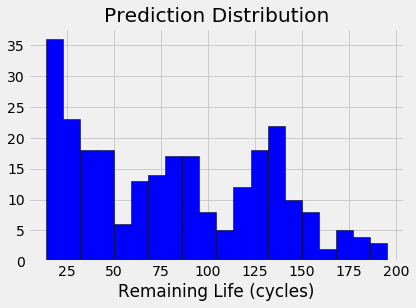

In [71]:
plt.hist(preds, bins = 20, color = 'blue', edgecolor = 'k')
plt.title('Prediction Distribution'); plt.xlabel('Remaining Life (cycles)');

,feature,importance,importance_normalized,cumulative_importance
0,operational_setting_1-sum,0.402817,0.402817,0.402817
1,time_in_cycles-sum,0.162060,0.162060,0.564877
2,sensor_measurement_11-max,0.095726,0.095726,0.660603
3,sensor_measurement_15-max,0.058629,0.058629,0.719232
4,sensor_measurement_13-max,0.021799,0.021799,0.741031


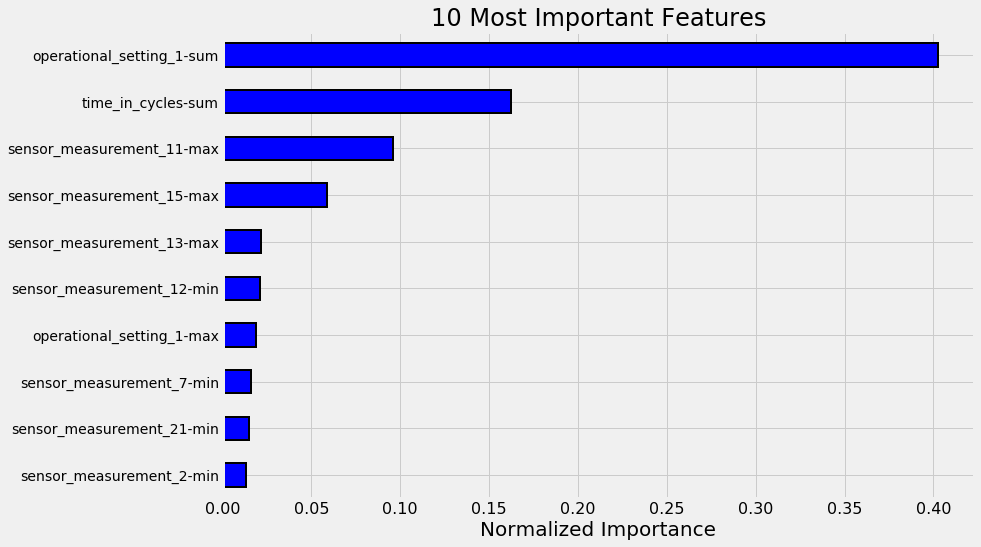

In [72]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head()

Through feature selection, we built model with a better succes rate. The most important features, operation_setting and time_in_cycles are our greatest predictor. To get more info about how engine should work longer we should also watch sensors 11 to 15 to get some idea about monitoring engines.

In [73]:
train_fs.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-std,operational_setting_3-mean,sensor_measurement_1-std,...,sensor_measurement_2-std,sensor_measurement_20-min,sensor_measurement_21-min,sensor_measurement_3-min,sensor_measurement_4-min,sensor_measurement_6-min,sensor_measurement_7-min,sensor_measurement_9-min,sensor_measurement_9-max,time_in_cycles-sum
0,0.0000,42.0077,25.414484,3024.3236,15.300117,0.8419,0.590210,0.315502,93.277311,27.467065,...,38.696380,10.36,6.2655,1256.76,1040.99,5.71,137.57,7993.23,9051.13,7140
1,0.0000,42.0076,23.734917,3370.3582,14.711035,0.8420,0.571921,0.310070,93.239437,26.707534,...,38.276363,10.37,6.2350,1253.86,1041.62,5.71,138.15,8005.94,9074.03,10153
2,0.0002,42.0073,25.365650,2029.2520,13.972098,0.8420,0.600951,0.282966,94.500000,23.920742,...,33.686785,10.41,6.2373,1255.74,1035.67,5.71,137.85,8007.77,9060.51,3240
3,0.0004,42.0075,23.640294,1891.2235,15.508015,0.8415,0.563961,0.323623,96.000000,27.701499,...,37.826324,10.44,6.2519,1257.79,1043.12,5.71,138.09,8004.46,9061.68,3240
4,0.0008,42.0071,21.721191,695.0781,14.481060,0.8417,0.528438,0.319769,93.750000,26.122518,...,37.739928,10.48,6.3157,1255.29,1037.43,5.71,138.32,8009.47,9066.37,528


In [74]:
train_fs['time_in_cycles-max'] = list(train_agg['time_in_cycles-max'])
train_fs.to_csv('simple_manual_features.csv')

#### Step 18 - More Advanced Feature Engineering // Optional step

Trying building a better model, applying more advanced feature engineering techinques may be necessary. We will apply time-series operation to each engine since our data is in time series. For example, we can find the percentage change and the cumulative sum for each engine.

In [75]:
train_obs = train_obs.sort_values(['engine_no', 'time_in_cycles'])
train_obs.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_25,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time_in_cycles
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,NaN,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,NaN,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,3
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,NaN,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,4
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,NaN,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,5


#### Step 19 - Time series operation.

Trying to find the percentage change and the cumulative sum for each engine.

In [76]:
train_exp = train_obs.copy()

# Find percentage change and cumulative sum for each engine
for col in train_obs:
    train_exp[f'{col}_pct_change'] = train_obs.groupby('engine_no')[col].apply(lambda x: x.pct_change())
    train_exp[f'{col}_cum_sum'] = train_obs.groupby('engine_no')[col].apply(lambda x: np.cumsum(x))
    
train_exp.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_6_pct_change,sensor_measurement_6_cum_sum,sensor_measurement_7_pct_change,sensor_measurement_7_cum_sum,sensor_measurement_8_pct_change,sensor_measurement_8_cum_sum,sensor_measurement_9_pct_change,sensor_measurement_9_cum_sum,time_in_cycles_pct_change,time_in_cycles_cum_sum
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,8.00,NaN,194.64,NaN,2222.65,NaN,8341.91,NaN,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,-0.286250,13.71,-0.288379,333.15,-0.004985,4434.22,-0.004549,16645.87,1.000000,3
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,0.579685,22.73,0.268573,508.86,-0.134050,6349.33,-0.036433,24647.29,0.500000,6
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,-0.366962,28.44,-0.211997,647.32,0.154806,8560.91,0.037811,32951.25,0.333333,10
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,0.581436,37.47,0.264264,822.37,-0.134058,10476.01,-0.037419,40944.48,0.250000,15



Since this just created new columns of observations, we can take this data and aggregate it to get a single dataframe for testing with one row for each engine. The function below carries out the aggregations and renaming of columns.



In [77]:
def agg_and_rename(df, agg_variable):
    """Function to aggregate a dataframe"""
    
    df_agg = df.groupby(agg_variable).agg(['min', 'max', 'mean', 'sum', 'std'])

    new_cols = []

    # Create a rename set of columns
    for col in df_agg.columns.levels[0]:
        for stat in df_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    df_agg.columns = new_cols
    
    return df_agg

In [78]:
train_exp_agg = agg_and_rename(train_exp, 'engine_no')
train_exp_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,time_in_cycles_pct_change-min,time_in_cycles_pct_change-max,time_in_cycles_pct_change-mean,time_in_cycles_pct_change-sum,time_in_cycles_pct_change-std,time_in_cycles_cum_sum-min,time_in_cycles_cum_sum-max,time_in_cycles_cum_sum-mean,time_in_cycles_cum_sum-sum,time_in_cycles_cum_sum-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,0.008475,1.0,0.045357,5.352132,0.109143,1,7140,2420.0,287980,2153.248244
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,0.007092,1.0,0.039216,5.529517,0.100748,1,10153,3432.0,487344,3056.265695
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,0.012658,1.0,0.062696,4.952979,0.130179,1,3240,1107.0,88560,982.498855
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,0.012658,1.0,0.062696,4.952979,0.130179,1,3240,1107.0,88560,982.498855
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,0.032258,1.0,0.129911,4.027245,0.190614,1,528,187.0,5984,164.097532


#### Step 20 - Applying time series operation on test data.

Now we apply the same operation to the testing data, do feature selection on the training data, subset the testing data to the same columns as the training data, and then evaluate in the next step.

In [79]:
test_obs.drop(columns = 'time', inplace = True)
test_exp = test_obs.copy()

# Apply operations to testing data
for col in test_obs:
    test_exp[f'{col}_pct_change'] = test_obs.groupby('engine_no')[col].apply(lambda x: x.pct_change())
    test_exp[f'{col}_cum_sum'] = test_obs.groupby('engine_no')[col].apply(lambda x: np.cumsum(x))

test_exp_agg = agg_and_rename(test_exp, 'engine_no')

#### Step 21 - Feature selection and subseting of test data.

In [80]:
# Feature selection and subsetting of test data
train_exp_agg_fs = feature_selection(train_exp_agg, 90, 0.95)
test_exp_agg_fs = test_exp_agg[train_exp_agg_fs.columns]

Original shape:  (260, 455)
61 missing columns with threshold: 90.
34 zero variance columns.
267 collinear columns removed with threshold: 0.95.
Total columns removed:  362
Shape after feature selection: (260, 93).


#### Step 21 - Evaluate Performance after more advanced feature engineering

In [81]:
preds, fi = evaluate(train_exp_agg_fs, train_labels, test_exp_agg_fs, test_labels)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


5-fold CV MAPE: 50.29 with std: 6.95
The Random Forest test MAPE: 54.04.



It appears we may have reached the limits of what we can do with feature engineering given that we added more features and yet the performance did not increase. It's possible we are approaching Bayes error, which is the lowest possible error its possible to get on a problem. This is a function of noise in the data and latent (hidden) variables that we cannot measure. The problem with Bayes error is we can never know when we have reached that point, because it would require a model that we know for sure achieves that error rate.

,feature,importance,importance_normalized,cumulative_importance
0,operational_setting_1-sum,0.376995,0.376995,0.376995
1,sensor_measurement_11-max,0.084983,0.084983,0.461978
2,time_in_cycles_pct_change-min,0.047509,0.047509,0.509487
3,time_in_cycles_pct_change-sum,0.046002,0.046002,0.555489
4,sensor_measurement_15-max,0.044009,0.044009,0.599498


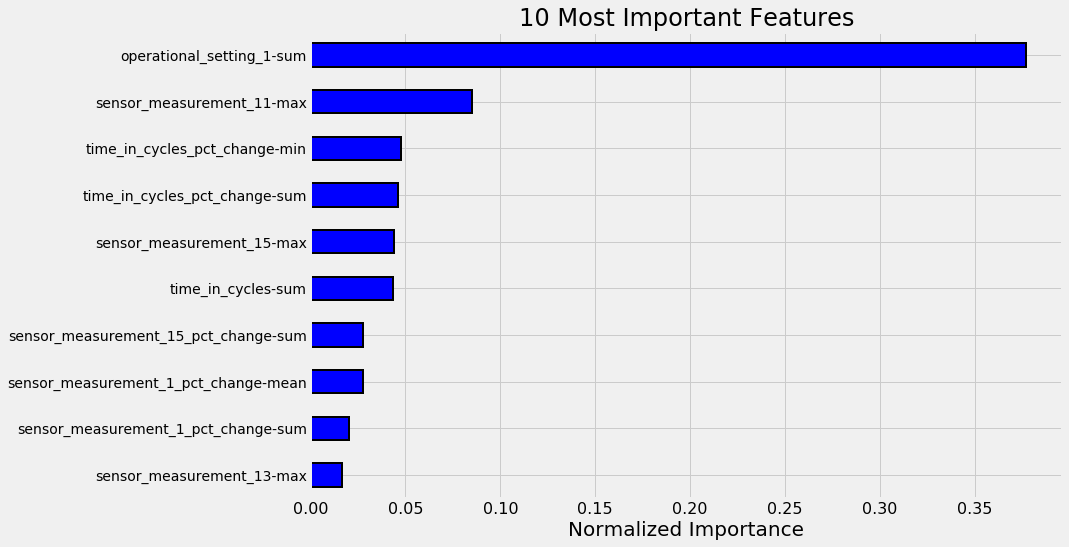

In [82]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head()


The model has about the same performance even with the added features. We can see some of the percentage change features we added as among the most important features.

#### Step 22 -  KMeans clustering and Time-Series Analysis

We will perform another manual feature engineering by using clustering and time-series analysis methods. 

This time, we will not use the pct_change and cum_sum because these features did not improve the model. The basic outline is:

-  Clustering: First we will cluster the observations into 10 unique clusters. We can then perform numerical aggregations on these clusters to get the information into our training dataframe.
-  Time-series analysis: Using the tsfresh package, we can apply a number of functions such as number_peaks and cid_ce.


In [95]:
from sklearn.cluster import KMeans

In [96]:

kmeans = KMeans(n_clusters = 10)

# Need to impute the missing values
imputer = Imputer(strategy='median')
train_cluster = imputer.fit_transform(train_obs.drop(columns = ['engine_no', 'time_in_cycles']))

# Create a new column with the cluster label
train_obs['cluster'] = kmeans.fit_predict(train_cluster)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



Next we apply the same procedure to the testing data (but just transform since we can only fit to training data).

The new column contains the cluster assigned to each observation. This will still require aggregating since it is on a per-observation level instead of for each engine.

In [97]:

test_cluster = imputer.transform(test_obs.drop(columns = ['engine_no', 'time_in_cycles']))
test_obs['cluster'] = kmeans.predict(test_cluster)

#### Step 23 -  Visualize Clusters

We can try to visualize the clusters by applying a UMAP embedding to the data. This reduces the dimension of data primarily for visualization.

In [98]:
import umap

reducer = umap.UMAP(n_components = 3)
train_embedding = reducer.fit_transform(train_cluster)

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

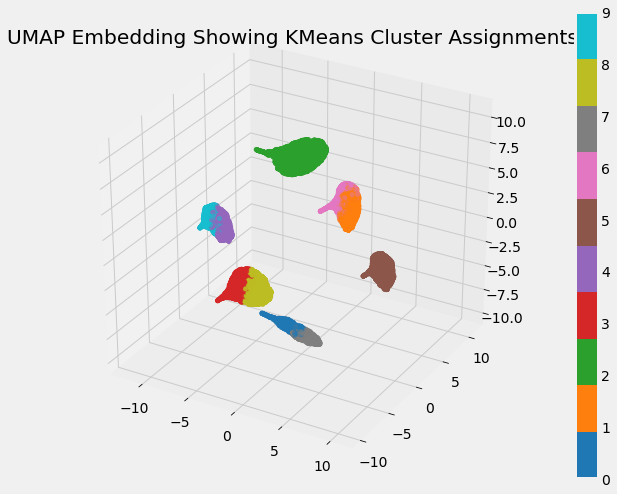

In [99]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap('tab10', 10)
p = ax.scatter(train_embedding[:, 0], train_embedding[:, 1], train_embedding[:, 2], 
               c = train_obs['cluster'], cmap = cmap)
plt.title('UMAP Embedding Showing KMeans Cluster Assignments')
fig.colorbar(p);


The UMAP embedding shows the clusters pretty clearly separate the observations, so perhaps they can be useful. Through clustering, we're hoping that observations that have the same cluster encode similar information which can then be used to predict how much longer an engine will run.

To get one observation per engine, we again have to aggregate by the engine_no. This time we will have five extra columns with the aggregations of the cluster assignments.

In [100]:
train_agg = agg_and_rename(train_obs, 'engine_no')
train_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std,cluster-min,cluster-max,cluster-mean,cluster-sum,cluster-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,1,119,60.0,7140,34.496377,1,8,3.815126,454,2.674317
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,1,142,71.5,10153,41.135953,0,9,4.429577,629,2.869250
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,1,80,40.5,3240,23.237900,0,9,3.725000,298,2.728077
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,1,80,40.5,3240,23.237900,0,9,3.850000,308,2.942917
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,1,32,16.5,528,9.380832,0,9,3.312500,106,2.740820


In [101]:
test_agg = agg_and_rename(test_obs, 'engine_no')



#### Step 24 - Time Series Operations using tsfresh
For the time series operations, we have any number of choices we can make from tsfresh. Each of these operations is applied to a single time-series and generates one number. To apply them we group by the the engine_no and then apply the operation to get a single observation per engine. We will choose five different operations:

-  cid_ce: measures the complexity of a time series
-  number_peaks: measures the number of peaks where a peak is bigger than n neighbors to the right and left
-  last_location_of_maximum: locates the last occurrence of the maximum value in the time series
-  skewness: the Fisher-Pearson skewness of the time series
-  sample_entropy: the sample entropy of the time series

All of these will be calculated for each operational setting and each sensor measurement giving us 5 new columns for each of the 29 original features (145 total features).

In [102]:
from tsfresh.feature_extraction.feature_calculators import (cid_ce, number_peaks, 
                                                             last_location_of_maximum, 
                                                             skewness, sample_entropy)

To avoid the issue of passing multiple functions to agg with the same name lambda, we have to create lambda functions and then give them custom names. cid_ce and number_peaks both have required arguments but the other functions only need a time-series.

In [103]:
cid_ce_func = lambda x: cid_ce(x, normalize=False)
cid_ce_func.__name__ = 'cid_ce'

n_peaks = lambda x: number_peaks(x, n = 5)
n_peaks.__name__ = 'number_peaks'

# Apply the five operations
ts_values = train_obs.drop(columns = ['time_in_cycles']).groupby('engine_no').agg([cid_ce_func, n_peaks, 
                                                                                   last_location_of_maximum,
                                                                                   skewness, sample_entropy])
ts_values.head()

operational_setting_1                                        \
                         cid_ce number_peaks last_location_of_maximum   
engine_no                                                               
1                    222.130414          7.0                 0.033613   
2                    249.163933         13.0                 0.464789   
3                    187.684211          7.0                 0.637500   
4                    187.265336          5.0                 0.875000   
5                    126.381589          2.0                 0.218750   

                                   operational_setting_2               \
           skewness sample_entropy                cid_ce number_peaks   
engine_no                                                               
1         -0.452181       1.666739              4.527149         10.0   
2         -0.256690       1.765438              5.263269         10.0   
3         -0.234855       1.714447              3.936826          7.0   
4         -0.201569       1.716206              3.947116          5.0   
5         -0.074413       1.929910              2.829646          2.0   

                                                                 ...        \
          last_location_of_maximum  skewness sample_entropy      ...         
engine_no                                                        ...         
1                         0.915966 -1.009877       1.297623      ...         
2                         0.584507 -0.910519       1.452252      ...         
3                         0.712500 -0.887928       1.333294      ...         
4                         0.225000 -0.815704       1.405464      ...         
5                         0.906250 -0.555121       1.581603      ...         

          sensor_measurement_9                                        \
                        cid_ce number_peaks last_location_of_maximum   
engine_no                                                              
1                  4830.565873          8.0                  0.94958   
2                  5441.308244          9.0                  0.56338   
3                  4019.268267          6.0                  0.82500   
4                  4059.046791          7.0                  0.12500   
5                  3108.209486          2.0                  0.71875   

                                      cluster               \
           skewness sample_entropy     cid_ce number_peaks   
engine_no                                                    
1          0.353665       1.215096  38.223030            2   
2          0.112458       1.285921  49.839743            5   
3          0.076565       1.161633  33.301652            5   
4          0.052436       1.227453  35.355339            7   
5         -0.053732       1.354546  21.189620            1   

                                                             
          last_location_of_maximum  skewness sample_entropy  
engine_no                                                    
1                         0.949580  0.406855       1.666739  
2                         0.985915  0.171693       1.850700  
3                         0.975000  0.266468       2.118156  
4                         1.000000  0.300610       2.163924  
5                         0.750000  0.582748       2.063441  

[5 rows x 150 columns]


Below we rename the columns.

In [104]:
new_cols = []

# Iterate through columns
for col in ts_values.columns.levels[0]:
    for stat in ts_values.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

In [105]:
ts_values.columns = new_cols


This dataframe can then be joined to the training data because there is one observation for each engine.

In [106]:
train_obs['engine_no'] = train_obs['engine_no'].astype(np.int32)

In [107]:
train_agg = train_agg.merge(ts_values, on = 'engine_no', how = 'outer')
train_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,sensor_measurement_9-cid_ce,sensor_measurement_9-number_peaks,sensor_measurement_9-last_location_of_maximum,sensor_measurement_9-skewness,sensor_measurement_9-sample_entropy,cluster-cid_ce,cluster-number_peaks,cluster-last_location_of_maximum,cluster-skewness,cluster-sample_entropy
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,4830.565873,8.0,0.94958,0.353665,1.215096,38.223030,2,0.949580,0.406855,1.666739
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,5441.308244,9.0,0.56338,0.112458,1.285921,49.839743,5,0.985915,0.171693,1.850700
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,4019.268267,6.0,0.82500,0.076565,1.161633,33.301652,5,0.975000,0.266468,2.118156
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,4059.046791,7.0,0.12500,0.052436,1.227453,35.355339,7,1.000000,0.300610,2.163924
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,3108.209486,2.0,0.71875,-0.053732,1.354546,21.189620,1,0.750000,0.582748,2.063441


We're up to 305 features (before feature selection). Now, we apply the same operations to the testing data.

In [108]:

# Apply the five operations
ts_values_test = test_obs.drop(columns = ['time_in_cycles']).groupby('engine_no').agg([cid_ce_func, n_peaks, 
                                                                                   last_location_of_maximum,
                                                                                   skewness, sample_entropy])

# Rename the columns
new_cols = []

for col in ts_values_test.columns.levels[0]:
    for stat in ts_values_test.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
        
ts_values_test.columns = new_cols

In [109]:
test_agg = test_agg.merge(ts_values_test, on = 'engine_no', how = 'outer')

***
#### Step 25 - Feature selection and model evaluation after time series operations

In [110]:

train_agg_fs = feature_selection(train_agg, 90, 0.95)
final_features = list(train_agg_fs.columns)
test_agg_fs = test_agg[train_agg_fs.columns]

Original shape:  (260, 305)
30 missing columns with threshold: 90.
32 zero variance columns.
153 collinear columns removed with threshold: 0.95.
Total columns removed:  215
Shape after feature selection: (260, 90).


In [111]:
preds = evaluate(train_agg_fs, train_labels, test_agg_fs, test_labels)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


5-fold CV MAPE: 48.22 with std: 5.12
The Random Forest test MAPE: 52.74.


***

#### Step 26 - Random Search

The model we used to evaluate the features was an unoptimized random forest. In order to make sure we are getting the most out of the model, we should perform random search over the hyperparameters. To do this, we can use RandomizedSearchCV from Scikit-Learn. 

The process is as follows:

Select a metric: we already made a scorer using MAPE

Define a hyperparameter grid over the search for the following hyperparameters:
- n_estimators
- max_depth
- min_samples_leaf
- max_features

Run random search for 100 iterations

Extract the best hyperparameters and use these for the final model

We will only use the random search on the final set of features because these had the best performance in cross validation.

In [112]:
from sklearn.model_selection import RandomizedSearchCV

scorer = mape_scorer

# Hyperparameter grid
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(50, 1000, num = 100)],
    'max_depth': [None] + [int(x) for x in np.linspace(4, 20)],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 0.5, 'log2', None]
}

In [113]:
# train_agg_fs = feature_selection(train_agg, 90, 0.95)
# final_features = list(train_agg_fs.columns)
# test_agg_fs = test_agg[train_agg_fs.columns]

In [114]:
# Make a model 
reg = RandomForestRegressor(n_jobs = -1, random_state = 50)

# RandomizedSearchCV object
random = RandomizedSearchCV(reg, param_grid, n_iter = 100, scoring = scorer, 
                            verbose = 1, n_jobs = -1, cv = 5, random_state = 50)

# Fit on the training data
random.fit(train_agg_fs, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=50, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 59, 69, 78, 88, 97, 107, 117, 126, 136, 145, 155, 165, 174, 184, 193, 203, 213, 222, 232, 241, 251, 261, 270, 280, 289, 299, 309, 318, 328, 337, 347, 357, 366, 376, 385, 395, 405, 414, 424, 433, 443, 453, 462, 472, 481, 491, 501, 510, 520, 529, 539, 548, 558...19, 19, 20], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': ['auto', 'sqrt', 0.5, 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=50, refit=

In [115]:

random.best_params_

{'n_estimators': 88,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 18}

*** 
#### Step 27 - Evaluate Best Model

We'll use the set of feature from aggregations, kmeans clustering, and time-series analysis along with the optimal hyperparameters to train one final model. Through random search with cross validation, we are making the assumption that the hyperparameters that do the best in cross validation will translate to doing well on the testing data.

In [116]:


best_score = -1 * random.best_score_
best_score_std = random.cv_results_['std_test_score'][np.argmax(random.cv_results_['mean_test_score'])]
best_model = random.best_estimator_

# Need to impute the values on the test data
imputer.fit(train_agg_fs)
test_agg_fs = test_agg_fs.replace({np.inf: np.nan})
test_agg_fs = imputer.transform(test_agg_fs)

In [117]:
# Make predictions on the. test data
preds = best_model.predict(test_agg_fs)
final_mape = mape(test_labels, preds)

print('5-fold Cross Validation MAPE: {:.2f} with std: {:.2f}'.format(best_score, best_score_std))
print('Test MAPE: {:.2f}.'.format(final_mape))

5-fold Cross Validation MAPE: 44.73 with std: 4.74
Test MAPE: 48.58.


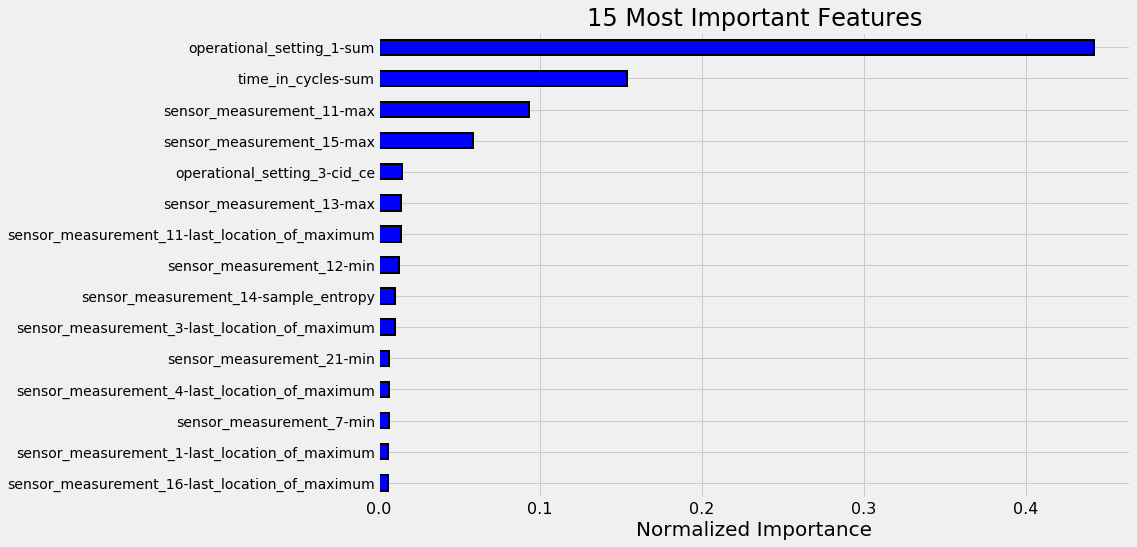

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

In [118]:
fi = pd.DataFrame({'feature': final_features, 'importance': best_model.feature_importances_})
norm_fi = plot_feature_importances(fi)

What we have reached by manual feature engineering:

Our best model is:
- Test MAPE: 48.58. - after randomizedsearchCV and Random forrest Regressor after time series analysis
- The Random Forest test MAPE: 54.04. - after simple feature engineering and time series operations
- The Random Forest test MAPE: 51.27. - without time series, after feature selection
- The average_guess train MAPE is: 158.89.
- The average_guess test MAPE is: 226.44.
- The Random Forest test MAPE: 232.47.

It does not appear that the KMeans clustering had much effect on the model because none of the top 15 most important features involve the cluster.

Overall, the simple aggregations and the more complex time-series methods, along with random search to optimize the hyperparameters, yields the best model performance on the test data.

***

### Step 29 - Conclusions after manual Feature Engineering:
After rounds of manual feature engineering, and performing few different calculating methods we can see that:

-  The best performing model used the simple aggregations, KMeans clustering, and time-series analysis features along with the optimized random forest model. 


These results highlight several important takeaways:

- Feature Engineering is critical. A simple baseline guess is very poor for this problem.
- Feature Selection is critical. The simple aggregation set of features resulted in significant overfitting to the training set before proper feature selection was applied.
-  Beyond a certain point, adding more complex features has diminishing returns to performance gains for this problem.
-  Model hyperparameter tuning can improve performance, but the gains are much smaller than those from feature engineering.

There were many more operations we could have applied to the data to generate features that we did not. For manual feature engineering, we are limited only by our imagination and patience. However, once we get to a certain level of performance, squeezing out every last bit of accuracy is secondary to model interpretability.

Manual feature engineering was effective for this problem and resulted in a model that significantly outperforms the baseline. Although it is:
- time-consuming
- error-vournerable
- does not translate between problems (we have to completely re-write the code for each dataset)

Next step present using feature engineering using automated method by FeatureTools. 
It will be:
- is significantly more efficient
- can be applied to any dataset with only minor changes in syntax
- and will allow us to create hundreds or thousands of features which are not limited by our creavity or our time.

## Predicting RUL using Automated Feature Engineering 

In the manual version of the problem, we defined the prediction problem by selecting Cutoff Points (prediction_point) in the data for each engine and then using the label as the number of cycles from this point to failure. The observational data was subsetted to only periods from before this prediction point to ensure the data is valid for each engine.

To make a fair comparison between manual and automated approaches, we'll load in the same prediction problem and data.

Roadmap
Once we have the data segmented into labels and allowable training data we can start working with automated feature engineering using Featuretools involving the following steps:

-  Creating an EntitySet and adding entities to it
-  Adding a dataframe and then normalize to create parent-child tables
-  Adding relationships between Entities
-  Run deep feature synthesis (DFS) using basic primitives
-  Define custom primitives to enhance the capabilities of featuretools
-  Evaluate feature sets using a default Random Forest Regressor
-  Optimize the machine learning model using random search

***

In [148]:
import pandas as pd
import numpy as np

import featuretools as ft
import featuretools.variable_types as vtypes

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

from utils import feature_selection, plot_feature_importances, evaluate, random_search

In [149]:
train = pd.read_csv('..train_obs.csv').reset_index()
train.head()

,index,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,...,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time,time_in_cycles
0,0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,...,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,2010-01-01 00:10:00,1
1,1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,...,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2010-01-01 00:20:00,2
2,2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,...,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,2010-01-01 00:30:00,3
3,3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,...,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,2010-01-01 00:40:00,4
4,4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,...,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,2010-01-01 00:50:00,5


#### Step 1 AFE - EntitySet and Entities

We will define an EntitySet and add our entities to it. This is a single data structure that keeps track of all our data tables and the relationships between them. Our data does have a time_index so we want to specify that when we add it as an entity to the EntitySet.

In [150]:
es = ft.EntitySet(id = 'engines')

# Make an entity from the observations data
es = es.entity_from_dataframe(dataframe = train,
                              entity_id = 'obs',
                              index = 'index', 
                              time_index = 'time')

#### Step 2 AFE - Normalizing Data and Relationships

In the manual engineering notebook, we created features by grouping and aggregating the observations for each engine and then creating a final table with one row for each engine. We'll use the same idea in Featuretools.

First we'll normalize the obs data by the engine. This will create a table with one row for each engine where the index is the engine_no. Then, when we build features from the observational data, we can specify that we want to build the features for the engines. 
Featuretools will automatically perform the aggregations of the observations on each engine for us. We can normalize an entity using normalize_entity with the following arguments:

-  base_entity_id: the table where our new table is drawn from. In this case, the obs table because each engine is represented multiple times in this data
-  new_entity_id the name given to the new table
-  index: the unique identifier for the table. This is the engine_no because it is unique to each engine

By using normalize_entity in FT deifning the table relationships(specyfing the parent variable and the child variable) is done automatically. The implemented FT function will add a relationship mapping the index in the new entity to the index in the original entity.

In [151]:
# Create a new table with unique engines
es.normalize_entity(base_entity_id = 'obs',
                    new_entity_id = 'engines', 
                    index = 'engine_no')
es

Entityset: engines
  Entities:
    obs [Rows: 27403, Columns: 33]
    engines [Rows: 260, Columns: 2]
  Relationships:
    obs.engine_no -> engines.engine_no

#### Step 3 AFE - Deep Feature Synthesis and Feature Primitives

To understand Deep Feature Synthesis (DFS), we first have to grasp feature primitives. A feature primitive at a very high-level is an operation applied to data to create a feature. Primitives are often operations that we would apply by hand to build our features. In Featuretools these simple calculations can be stacked on top of each other to create complex deep features. Feature primitives fall into two categories:

Aggregation (agg): function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
Transformation (trans): an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.
Deep feature synthesis takes feature primitives and stacks them on top of each other to create new features. The depth of a feature is the number of primitives stacked, so, for example, taking the mean of a maximum would be a feature of depth 2. Because we only have two tables in this case, we'll first stick to features with depth of 1. When doing manual engineering, all of the features we created were essentially "deep features" with a depth of 1 since we made them by aggregating child observations for each parent. Featuretools will do this for us in deep feature synthesis but with code that can applied to any problem rather than one specific dataset.

Let's take a look at a basic example of running deep feature synthesis using ft.dfs. We'll specify to build the features for each engine (target_entity = engines), list a few agg and trans primitives, a maximum depth of 1, and n_jobs=-1 to run on all cores.

In [152]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='engines',
                                       agg_primitives = ['min', 'max', 'mean', 
                                                         'count', 'sum'],
                                       trans_primitives = ['cum_mean', 'cum_sum'],
                                       max_depth = 1, n_jobs = -1, verbose = 1)
feature_matrix.head()

Built 121 features
EntitySet scattered to workers in 1.236 seconds
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,SUM(obs.sensor_measurement_25),SUM(obs.sensor_measurement_26),SUM(obs.sensor_measurement_3),SUM(obs.sensor_measurement_4),SUM(obs.sensor_measurement_5),SUM(obs.sensor_measurement_6),SUM(obs.sensor_measurement_7),SUM(obs.sensor_measurement_8),SUM(obs.sensor_measurement_9),SUM(obs.time_in_cycles)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,0.0,60.0,445.0,0.94,36.57,129.63,2027.94,7857.51,8.3892,...,0.0,0.0,167857.48,142356.09,921.72,1327.32,32158.79,263824.67,1008630.06,7140
2,0.0000,0.0,60.0,445.0,0.94,36.51,129.80,2028.29,7875.70,8.4025,...,0.0,0.0,201442.37,170827.10,1153.54,1662.56,40386.26,315855.94,1210648.08,10153
3,0.0002,0.0,60.0,445.0,0.94,36.33,130.27,2028.18,7868.28,8.3688,...,0.0,0.0,112678.09,95167.59,608.09,877.83,21384.34,178044.03,679699.26,3240
4,0.0004,0.0,60.0,445.0,0.94,36.54,130.11,2028.23,7870.69,8.3926,...,0.0,0.0,114471.08,97170.46,656.30,953.40,23466.69,180005.40,685010.11,3240
5,0.0008,0.0,60.0,445.0,0.94,36.53,130.15,2028.30,7876.75,8.3771,...,0.0,0.0,45563.35,38665.95,271.82,392.79,9616.07,71443.66,273539.44,528


We now have 120+ features for modeling. We can easily make many more features by specifying more primitives. In contrast to manual feature engineering where adding a new feature might mean hours of work, Featuretools lets us drastically increase the number of features by simply adding another primitive which will stack on top of the existing features where possible.

#### Step 4 AFE - Testing Data

We'll want to apply the same operations (make the same features) to our test data. We can load in the test data and create a separate EntitySet (for this problem, a separate EntitySet is probably the easiest way to keep track of the training and testing information).

In [153]:
test = pd.read_csv('..test_obs.csv').reset_index()
test_es = ft.EntitySet(id = 'test_engines')
test_es = test_es.entity_from_dataframe(dataframe = test,
                                        entity_id='obs', 
                                        index = 'index',
                                        time_index = 'time')

We'll want to normalize this table as well by each engine.

In [154]:
test_es.normalize_entity(base_entity_id='obs',
                         new_entity_id = 'engines', 
                         index = 'engine_no')
test_es

Entityset: test_engines
  Entities:
    obs [Rows: 33991, Columns: 33]
    engines [Rows: 259, Columns: 2]
  Relationships:
    obs.engine_no -> engines.engine_no

We already have the features we need to make, feature_names, so we don't need to run ft.dfs but instead can use calculate_feature_matrix passing the list of features. This will create the exact same features for the testing data are in the training data.

In [155]:
test_feature_matrix = ft.calculate_feature_matrix(feature_names, entityset=test_es, 
                                                   n_jobs = -1, verbose = 1)
test_feature_matrix.head()

EntitySet scattered to workers in 1.209 seconds
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,SUM(obs.sensor_measurement_25),SUM(obs.sensor_measurement_26),SUM(obs.sensor_measurement_3),SUM(obs.sensor_measurement_4),SUM(obs.sensor_measurement_5),SUM(obs.sensor_measurement_6),SUM(obs.sensor_measurement_7),SUM(obs.sensor_measurement_8),SUM(obs.sensor_measurement_9),SUM(obs.time_in_cycles)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0002,0.0,60.0,445.0,0.94,36.63,129.87,2027.98,7859.50,8.3979,...,0.0,0.0,365852.93,310705.54,2067.99,2983.00,72432.81,574052.65,2196234.25,33411
2,0.0005,0.0,60.0,445.0,0.94,36.63,130.02,2028.17,7869.69,8.4109,...,0.0,0.0,77260.48,65417.57,407.78,588.29,14295.57,122019.18,466194.60,1540
3,0.0001,0.0,60.0,445.0,0.94,36.59,129.89,2028.06,7862.27,8.4025,...,0.0,0.0,235773.08,200467.73,1379.31,1998.94,49055.52,369804.67,1410116.72,13695
4,0.0002,0.0,60.0,445.0,0.94,36.71,130.22,2028.20,7871.40,8.4160,...,0.0,0.0,121471.49,103256.24,684.67,984.68,23831.89,190448.55,730989.67,3741
5,0.0000,0.0,60.0,445.0,0.94,36.43,129.98,2028.23,7869.72,8.3882,...,0.0,0.0,209799.80,177772.71,1198.35,1726.81,41889.31,328990.59,1261714.29,11026


#### Step 5 AFS - Modeling

We can now use the training data for training a model and the testing data for making predictions. First we'll load in the labels.

In [156]:
# Load in the labels for training 
train_labels = np.array(pd.read_csv('..engines_4.csv')['label']).reshape((-1, ))
test_labels = np.array(pd.read_csv('RUL_FD002.txt', sep=' ', 
                                   header=-1, names=['label'], index_col=False)['label']).reshape((-1, ))

#### Step 6 AFS - Feature Selection

We can use the feature_selection function previously developed in order to limit the amout of features (because some may be irrelevant or redudant). In the manual feature engineering notebook, we saw the importance of feature selection as it increased our score from no better than guessing to a model that reduced the baseline error by 75%.

In [157]:
feature_matrix = feature_selection(feature_matrix, correlation_threshold=0.9)
test_feature_matrix = test_feature_matrix[feature_matrix.columns]

Original shape:  (260, 121)
15 missing columns with threshold: 90.
15 zero variance columns.
63 collinear columns removed with threshold: 0.9.
Total columns removed:  93
Shape after feature selection: (260, 28).


#### Step 7 AFS - Model Evaluation

In [158]:
preds, fi = evaluate(feature_matrix, train_labels, test_feature_matrix, test_labels)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


5-fold CV MAPE: 46.17 with std: 4.34
Test MAPE: 48.91.


With just a simple implementation of Featuretools, we already have a model that outperformed the manual model.

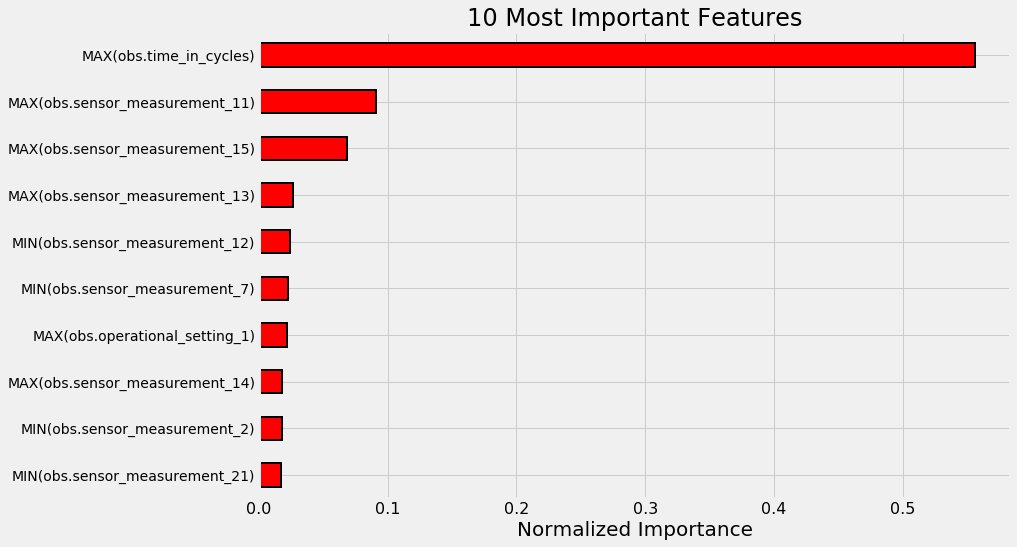

distributed.core - INFO - Event loop was unresponsive in Nanny for 39.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

In [159]:
norm_fi = plot_feature_importances(fi, 10, color = 'red')

***

#### Conclusion

We can acheive very good results from Automated Feature Engineering by using few steps. Moreover, the most important feature makes intuitive sense: the total number of previous cycles is likely the most indicative indicator of when an engine will fail. We can also see that sensors 11 and 15 are very important which could indicate to the engineers they should focus on these sensors while the engine is running.

# Featuretools solution - Automatic Feature Engineering

In the manual way, we defined the prediction problem by selecting Cutoff Points (which we called a prediction_point) in the data for each engine and then using the label as the number of cycles from this point to failure. The observational data was subsetted to only periods from before this prediction point to ensure the data is valid for each engine. To make a fair comparison between manual and automated approaches, we'll load in the same exact prediction problem and data.

The metric we established is Mean Absolute Percentage Error (MAPE), an interpretable measure that is the percentage error from our predictions. We'll measure MAPE both in 5-fold cross validation on the training data and on the test data (for which we know the true labels).
***

Roadmap

This is a fairly straightforward time-series problem once we have the data segmented into labels and allowable training data. Automated feature engineering using Featuretools involves the following steps

- Understand the Data
- Generate features
- Make predictions with Machine Learning

***

#### Step 1 - Data Load

After we tried to manualy create features now we will try to recreate process by finding features autmoaticaly using featuretools.

In [134]:
import numpy as np
import pandas as pd
import featuretools as ft
import utils2
from random import randint
import requests, zipfile
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import os

data_path = 'train_FD002.txt'
data = utils2.load_data(data_path)
data.head()

Loaded data with:
53759 Recordings
260 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,0,2000-01-01 00:00:00
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,1,2000-01-01 00:10:00
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,2,2000-01-01 00:20:00
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,3,2000-01-01 00:30:00
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,4,2000-01-01 00:40:00


#### Step 2 - Describing the prediction problem.

As in previous solution we have to create cutoff_times. In this dataset we have engines (engine_no) which are monitored over time (time_in_cycles). Each engine had operational_settings and sensor_measurements recorded for each cycle. The Remaining Useful Life (RUL) is the amount of cycles an engine has left before it needs maintenance. What makes this dataset special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time.

To train a model that will predict RUL, we can can simulate real predictions on by choosing a random point in the life of the engine and only using the data from before that point. We can create features with that restriction easily by using cutoff_times in Featuretools.

The function make_cutoff_times in utils does that sampling for both the cutoff_time and the label. You can run the next cell several times and see differing results.

In [135]:
def new_labels(data, labels):
    ct_ids = []
    ct_times = []
    ct_labels = []
    data = data.copy()
    data['RUL'] = labels
    gb = data.groupby(['engine_no'])
    for engine_no_df in gb:
        instances = engine_no_df[1].shape[0]
        r = randint(5, instances - 1)
        ct_ids.append(engine_no_df[1].iloc[r,:]['engine_no'])
        ct_times.append(engine_no_df[1].iloc[r,:]['time'])
        ct_labels.append(engine_no_df[1].iloc[r,:]['RUL'])
    ct = pd.DataFrame({'engine_no': ct_ids,
                       'cutoff_time': ct_times,
                       'RUL': ct_labels})
    ct = ct[['engine_no', 'cutoff_time', 'RUL']]
    ct.index = ct['engine_no']
    ct.index = ct.index.rename('index')
    return ct
def make_cutoff_times(data):
    gb = data.groupby(['engine_no'])
    labels = []


    for engine_no_df in gb:
        instances = engine_no_df[1].shape[0]
        label = [instances - i - 1 for i in range(instances)]
        labels += label
    
    return new_labels(data, labels)

cutoff_times = make_cutoff_times(data)

cutoff_times.head()

,engine_no,cutoff_time,RUL
index,,,
1,1,2000-01-01 18:50:00,35
2,2,2000-01-03 16:30:00,30
3,3,2000-01-04 18:30:00,80
4,4,2000-01-05 11:10:00,215
5,5,2000-01-07 21:10:00,21



Let's walk through a row of the cutoff_times dataframe. In the third row, we have engine number 3. At 3:20 on January 6, the remaining useful life of engine number 3 is 213. Having a dataframe in this format tells Featuretools that the feature vector for engine number 3 should only be calculated with data from before that point in time.

To apply Deep Feature Synthesis we need to establish an EntitySet structure for our data. The key insight in this step is that we're really interested in our data as collected by engine. We can create an engines entity by normalizing by the engine_no column in the raw data. In the next section, we'll create a feature matrix for the engines entity directly rather than the base dataframe of recordings.

#### Step 3 - Building Entityset

In [136]:

def make_entityset(data):
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=data,
                             entity_id='recordings',
                             index='index',
                             time_index='time')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='engines',
                        index='engine_no')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='cycles',
                        index='time_in_cycles')
    return es
es = make_entityset(data)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 53759, Columns: 28]
    engines [Rows: 260, Columns: 2]
    cycles [Rows: 378, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

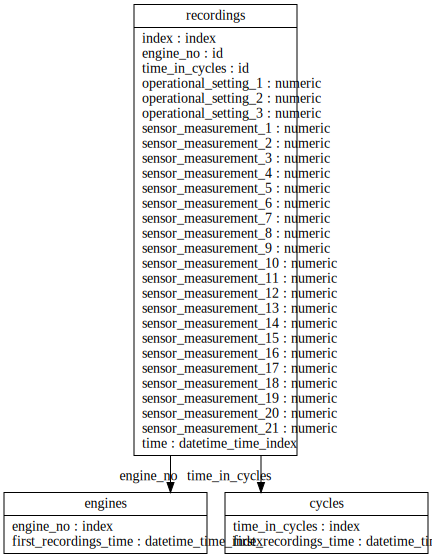

In [137]:
es.plot()

#### Step 4 - Deep Feature Synthesis

To understand Deep Feature Synthesis (DFS), we first have to grasp feature primitives. A feature primitive at a very high-level is an operation applied to data to create a feature. Primitives are often operations that we would apply by hand to build our features. In Featuretools these simple calculations can be stacked on top of each other to create complex deep features. Feature primitives fall into two categories:

Aggregation (agg): function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
Transformation (trans): an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.
Deep feature synthesis takes feature primitives and stacks them on top of each other to create new features. The depth of a feature is the number of primitives stacked, so, for example, taking the mean of a maximum would be a feature of depth 2. Because we only have two tables in this case, we'll first stick to features with depth of 1. When doing manual engineering, all of the features we created were essentially "deep features" with a depth of 1 since we made them by aggregating child observations for each parent. Featuretools will do this for us in deep feature synthesis but with code that can applied to any problem rather than one specific dataset.

Let's take a look at a basic example of running deep feature synthesis using ft.dfs. We'll specify to build the features for each engine (target_entity = engines), list a few agg and trans primitives, a maximum depth of 1, and n_jobs=-1 to run on all cores.

In [138]:
fm, features = ft.dfs(entityset=es, 
                      target_entity='engines',
                      agg_primitives=['last', 'max', 'min'],
                      trans_primitives=[],
                      cutoff_time=cutoff_times,
                      max_depth=3,
                      verbose=True)
fm.to_csv('simple_fm.csv')

Built 290 features
Elapsed: 04:19 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


#### Step 5 - Creating Baselines 

In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

fm = pd.read_csv('simple_fm.csv', index_col='engine_no')
X = fm.copy().fillna(0)
y = X.pop('RUL')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

medianpredict1 = [np.median(y_train) for _ in y_test]
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict1, y_test)))

Baseline by median label: Mean Abs Error = 41.46


In [140]:
recordings_from_train = es['recordings'].df[es['recordings'].df['engine_no'].isin(y_train.index)]
median_life = np.median(recordings_from_train.groupby(['engine_no']).apply(lambda df: df.shape[0]))

recordings_from_test = es['recordings'].df[es['recordings'].df['engine_no'].isin(y_test.index)]
life_in_test = recordings_from_test.groupby(['engine_no']).apply(lambda df: df.shape[0])-y_test

medianpredict2 = (median_life - life_in_test).apply(lambda row: max(row, 0))
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict2, y_test)))

Baseline by median life: Mean Abs Error = 50.57


#### Step 6 - Using the model
We can use our created features to fit a RandomForestRegressor to our data and see if we can improve on the previous scores.

In [142]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)
    
preds = reg.predict(X_test)
scores = mean_absolute_error(preds, y_test)
print('Mean Abs Error: {:.2f}'.format(scores))
high_imp_feats = utils2.feature_importances(X, reg, feats=10)

Mean Abs Error: 27.62
1: MAX(recordings.cycles.MAX(recordings.sensor_measurement_4)) [0.246]
2: LAST(recordings.time_in_cycles) [0.104]
3: MAX(recordings.cycles.MAX(recordings.sensor_measurement_3)) [0.091]
4: MAX(recordings.cycles.LAST(recordings.sensor_measurement_15)) [0.049]
5: MAX(recordings.cycles.LAST(recordings.sensor_measurement_11)) [0.047]
6: MAX(recordings.sensor_measurement_11) [0.045]
7: MAX(recordings.sensor_measurement_15) [0.031]
8: MAX(recordings.cycles.MAX(recordings.sensor_measurement_15)) [0.031]
9: MAX(recordings.cycles.LAST(recordings.sensor_measurement_4)) [0.021]
10: MAX(recordings.sensor_measurement_2) [0.014]
-----



Performing same as above but on our test data

In [145]:
data2 = utils2.load_data('test_FD002.txt')
es2 = make_entityset(data2)
fm2 = ft.calculate_feature_matrix(entityset=es2, features=features, verbose=True)
fm2.head()

Loaded data with:
33991 Recordings
259 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:21 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,LAST(recordings.time_in_cycles),LAST(recordings.operational_setting_1),LAST(recordings.operational_setting_2),LAST(recordings.operational_setting_3),LAST(recordings.sensor_measurement_1),LAST(recordings.sensor_measurement_2),LAST(recordings.sensor_measurement_3),LAST(recordings.sensor_measurement_4),LAST(recordings.sensor_measurement_5),LAST(recordings.sensor_measurement_6),...,MIN(recordings.cycles.MIN(recordings.sensor_measurement_12)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_13)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_14)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_15)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_16)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_17)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_18)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_19)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_20)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_21))
engine_no,,,,,,,,,,,,,,,,,,,,,
1,258,10.0076,0.2501,100.0,489.05,605.42,1515.00,1325.07,10.52,15.50,...,129.31,2027.79,7851.31,8.3302,0.02,303,1915,84.93,10.18,6.1231
2,55,0.0018,0.0000,100.0,518.67,642.67,1591.67,1418.17,14.62,21.61,...,129.43,2027.89,7854.86,8.3302,0.02,303,1915,84.93,10.18,6.1388
3,165,35.0015,0.8412,100.0,449.44,555.86,1370.62,1135.59,5.48,8.00,...,129.31,2027.79,7851.31,8.3302,0.02,303,1915,84.93,10.18,6.1231
4,86,20.0032,0.7000,100.0,491.19,607.99,1487.94,1257.49,9.35,13.66,...,129.43,2027.87,7854.86,8.3302,0.02,303,1915,84.93,10.18,6.1388
5,148,42.0055,0.8400,100.0,445.00,550.81,1358.95,1140.34,3.91,5.72,...,129.43,2027.79,7851.31,8.3302,0.02,303,1915,84.93,10.18,6.1231


In [147]:
X = fm2.copy().fillna(0)
y = pd.read_csv('RUL_FD002.txt', sep=' ', header=-1, names=['RUL'], index_col=False)
preds2 = reg.predict(X)
print('Mean Abs Error: {:.2f}'.format(mean_absolute_error(preds2, y)))

medianpredict1 = [np.median(y_train) for _ in preds2]
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict1, y)))

medianpredict2 = (median_life - es2['recordings'].df.groupby(['engine_no']).apply(lambda df: df.shape[0])).apply(lambda row: max(row, 0))
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict2, y)))

Mean Abs Error: 29.12
Baseline by median label: Mean Abs Error = 46.03
Baseline by median life: Mean Abs Error = 33.56


### More Advanced Feature Engineering using KMean Clustering and Hyperparameter Tuning

#### Step 1 - Data Load

After we tried to manualy create features now we will try to recreate process by finding features autmoaticaly using featuretools.

In [119]:
import numpy as np
import pandas as pd
import featuretools as ft
import utils2

data_path = 'train_FD002.txt'
data = utils2.load_data(data_path)

data.head()

Loaded data with:
53759 Recordings
260 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,0,2000-01-01 00:00:00
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,1,2000-01-01 00:10:00
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,2,2000-01-01 00:20:00
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,3,2000-01-01 00:30:00
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,4,2000-01-01 00:40:00


#### Step 2 - Creating  cutoff time for each engine.

We also make cutoff times by selecting a random cutoff time from the life of each engine. We're going to make 5 sets of cutoff times to use for cross validation.

In [120]:
from tqdm import tqdm

splits = 5
cutoff_time_list = []

for i in tqdm(range(splits)):
    cutoff_time_list.append(utils2.make_cutoff_times(data))

cutoff_time_list[0].head()

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


,engine_no,cutoff_time,RUL
index,,,
1,1,2000-01-01 09:10:00,93
2,2,2000-01-02 10:10:00,212
3,3,2000-01-04 23:30:00,50
4,4,2000-01-06 16:00:00,42
5,5,2000-01-07 11:40:00,78


#### Step 3 - KMean Clustering
The values for operational_setting 1-3 are continuous but create relation between different engines. If two engines have a similar operational_setting, it could indicate that we should expect the sensor measurements to mean similar things. We make clusters of those settings using KMeans from scikit-learn and make a new entity from the clusters.

In [121]:
from sklearn.cluster import KMeans

nclusters = 50

def make_entityset(data, nclusters, kmeans=None):
    X = data[['operational_setting_1', 'operational_setting_2', 'operational_setting_3']]
    if kmeans:
        kmeans=kmeans
    else:
        kmeans = KMeans(n_clusters=nclusters).fit(X)
    data['settings_clusters'] = kmeans.predict(X)
    
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=data,
                             entity_id='recordings',
                             index='index',
                             time_index='time')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='engines',
                        index='engine_no')
    
    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='settings_clusters',
                        index='settings_clusters')
    
    return es, kmeans
es, kmeans = make_entityset(data, nclusters)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 53759, Columns: 29]
    engines [Rows: 260, Columns: 2]
    settings_clusters [Rows: 50, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.settings_clusters -> settings_clusters.settings_clusters

#### Step 4 -  Visualise Entity Set by graphviz library.

Visualising entity set by graphviz library.

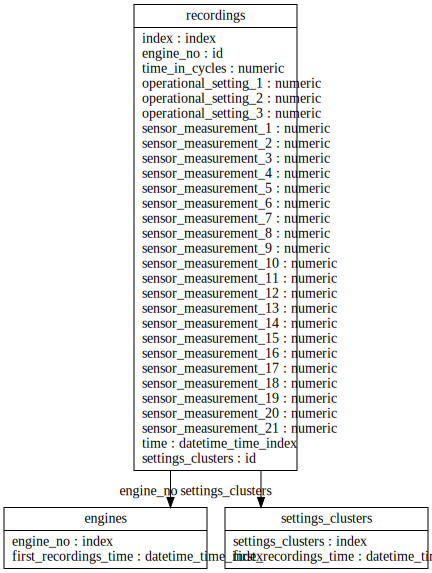

In [122]:
es.plot()

#### Step 5 - Time series operation by tsfresh and building features.

In addition to changing our EntitySet structure, we're also going to use the Complexity time series primitive from the package tsfresh. Any function that takes in a pandas Series and outputs a float can be converted into an aggregation primitive using the make_agg_primitive function as shown below.

In [123]:
from featuretools.primitives import make_agg_primitive
import featuretools.variable_types as vtypes

from tsfresh.feature_extraction.feature_calculators import (number_peaks, mean_abs_change, 
                                                            cid_ce, last_location_of_maximum, length)


Complexity = make_agg_primitive(lambda x: cid_ce(x, False),
                              input_types=[vtypes.Numeric],
                              return_type=vtypes.Numeric,
                              name="complexity")

fm, features = ft.dfs(entityset=es, 
                      target_entity='engines',
                      agg_primitives=['last', 'max', Complexity],
                      trans_primitives=[],
                      chunk_size=.26,
                      cutoff_time=cutoff_time_list[0],
                      max_depth=3,
                      verbose=True)

fm.to_csv('advanced_fm.csv')
fm.head()

Built 302 features
Elapsed: 03:57 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 4/4 chunks


,LAST(recordings.time_in_cycles),LAST(recordings.operational_setting_1),LAST(recordings.operational_setting_2),LAST(recordings.operational_setting_3),LAST(recordings.sensor_measurement_1),LAST(recordings.sensor_measurement_2),LAST(recordings.sensor_measurement_3),LAST(recordings.sensor_measurement_4),LAST(recordings.sensor_measurement_5),LAST(recordings.sensor_measurement_6),...,COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_13)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_14)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_15)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_16)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_17)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_18)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_19)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_20)),COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_21)),RUL
engine_no,,,,,,,,,,,,,,,,,,,,,
1,56,42.0043,0.8400,100.0,445.00,549.51,1345.58,1135.74,3.91,5.71,...,0.425391,27.860661,0.228966,0.000000,10.594126,0,0.0,1.179595,0.551619,93
2,57,20.0065,0.7018,100.0,491.19,607.46,1484.37,1252.06,9.35,13.66,...,1.936383,80.362837,0.497293,0.052915,21.284563,0,0.0,1.913760,1.208638,212
3,156,25.0054,0.6220,60.0,462.54,537.19,1268.60,1049.49,7.05,9.03,...,3.116301,118.096590,0.774691,0.118467,33.012243,0,0.0,2.894218,1.930128,50
4,193,35.0045,0.8400,100.0,449.44,555.97,1366.96,1137.44,5.48,8.00,...,3.205406,131.020399,1.085594,0.145283,45.217967,0,0.0,4.303930,2.638120,42
5,76,19.9990,0.7000,100.0,491.19,608.21,1483.84,1244.76,9.35,13.66,...,5.438558,335.435385,0.800281,0.090554,31.920835,0,0.0,2.829991,1.952488,78


We build 4 more feature matrices with the same feature set but different cutoff times. That lets us test the pipeline multiple times before using it on test data.

In [124]:

fm_list = [fm]
for i in tqdm(range(1, splits)):
    fm = ft.calculate_feature_matrix(entityset=make_entityset(data, nclusters, kmeans=kmeans)[0], 
                                     features=features, 
                                     chunk_size=.26, 
                                     cutoff_time=cutoff_time_list[i])
    fm_list.append(fm)

100%|██████████| 4/4 [17:45<00:00, 267.86s/it]


#### Step 6 - Model Evaluation

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
def pipeline_for_test(fm_list, hyperparams={'n_estimators':100, 'max_feats':50, 'nfeats':50}, do_selection=False):
    scores = []
    regs = []
    selectors = []
    for fm in fm_list:
        X = fm.copy().fillna(0)
        y = X.pop('RUL')
        reg = RandomForestRegressor(n_estimators=int(hyperparams['n_estimators']), 
                                    max_features=min(int(hyperparams['max_feats']), 
                                                     int(hyperparams['nfeats'])))
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        if do_selection:
            reg2 = RandomForestRegressor(n_estimators=10, n_jobs=3)
            selector = RFE(reg2, int(hyperparams['nfeats']), step=25)
            selector.fit(X_train, y_train)
            X_train = selector.transform(X_train)
            X_test = selector.transform(X_test)
            selectors.append(selector)
        reg.fit(X_train, y_train)
        regs.append(reg)
        
        preds = reg.predict(X_test)
        scores.append(mean_absolute_error(preds, y_test))
    return scores, regs, selectors    
scores, regs, selectors = pipeline_for_test(fm_list)
print([float('{:.1f}'.format(score)) for score in scores])
print('Average MAE: {:.1f}, Std: {:.2f}\n'.format(np.mean(scores), np.std(scores)))

most_imp_feats = utils2.feature_importances(fm_list[0], regs[0])

[26.6, 30.8, 29.4, 28.1, 28.7]
Average MAE: 28.7, Std: 1.39

1: COMPLEXITY(recordings.settings_clusters.MAX(recordings.sensor_measurement_16)) [0.040]
2: COMPLEXITY(recordings.sensor_measurement_18) [0.032]
3: COMPLEXITY(recordings.settings_clusters.MAX(recordings.sensor_measurement_8)) [0.029]
4: COMPLEXITY(recordings.sensor_measurement_10) [0.028]
5: COMPLEXITY(recordings.settings_clusters.MAX(recordings.sensor_measurement_17)) [0.024]
-----



In [126]:
data_test = utils2.load_data('test_FD002.txt')

es_test, _ = make_entityset(data_test, nclusters, kmeans=kmeans)
fm_test = ft.calculate_feature_matrix(entityset=es_test, features=features, verbose=True, chunk_size='cutoff time')
X = fm_test.copy().fillna(0)
y = pd.read_csv('RUL_FD002.txt', sep=' ', header=-1, names=['RUL'], index_col=False)
preds = regs[0].predict(X)
print('Mean Abs Error: {:.2f}'.format(mean_absolute_error(preds, y)))

Loaded data with:
33991 Recordings
259 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks
Mean Abs Error: 31.76



#### Step 7 - Feature Selection and Scoring

Here, we'll use Recursive Feature Elimination. In order to set ourselves up for later optimization, we're going to write a generic pipeline function which takes in a set of hyperparameters and returns a score. Our pipeline will first run RFE and then split the remaining data for scoring by a RandomForestRegressor. We're going to pass in a list of hyperparameters, which we will tune later.

Lastly, we can use that selector and regressor to score the test values.

#### Step 8 - Hyperparameter Tuning

Because of the way we set up our pipeline, we can use a Gaussian Process to tune the hyperparameters. We will use BTB from the HDI Project. This will search through the hyperparameters n_estimators and max_feats for RandomForest, and the number of features for RFE to find the hyperparameter set that has the best average score.

In [127]:
from btb import HyperParameter, ParamTypes
from btb.tuning import GP

def run_btb(fm_list, n=30):
    hyperparam_ranges = [
            ('n_estimators', HyperParameter(ParamTypes.INT, [10, 200])),
            ('max_feats', HyperParameter(ParamTypes.INT, [5, 50])),
            ('nfeats', HyperParameter(ParamTypes.INT, [10, 70])),
    ]
    tuner = GP(hyperparam_ranges)

    tested_parameters = np.zeros((n, len(hyperparam_ranges)), dtype=object)
    scores = []
    
    print('[n_est, max_feats, nfeats]')
    best = 45

    for i in tqdm(range(n)):
        hyperparams = tuner.propose()
        cvscores, regs, selectors = pipeline_for_test(fm_list, hyperparams=hyperparams, do_selection=True)
        bound = np.mean(cvscores)
        tested_parameters[i, :] = hyperparams
        tuner.add(hyperparams, -np.mean(cvscores))
        if np.mean(cvscores) + np.std(cvscores) < best:
            best = np.mean(cvscores)
            best_hyperparams = hyperparams
            best_reg = regs[0]
            best_sel = selectors[0]
            print('{}. {} -- Average MAE: {:.1f}, Std: {:.2f}'.format(i, 
                                                                      best_hyperparams, 
                                                                      np.mean(cvscores), 
                                                                      np.std(cvscores)))
            print('Raw: {}'.format([float('{:.1f}'.format(s)) for s in cvscores]))

    return best_hyperparams, (best_sel, best_reg)

best_hyperparams, best_pipeline = run_btb(fm_list, n=30)

  0%|          | 0/30 [00:00<?, ?it/s]

[n_est, max_feats, nfeats]


  3%|▎         | 1/30 [00:15<07:30, 15.54s/it]

0. {'n_estimators': 191, 'max_feats': 30, 'nfeats': 50} -- Average MAE: 29.0, Std: 1.60
Raw: [30.2, 28.8, 29.8, 25.9, 30.0]


 10%|█         | 3/30 [00:42<06:29, 14.44s/it]

2. {'n_estimators': 46, 'max_feats': 40, 'nfeats': 57} -- Average MAE: 26.7, Std: 1.29
Raw: [27.0, 24.5, 28.4, 26.4, 27.4]


100%|██████████| 30/30 [06:42<00:00, 13.81s/it]


#### Step 9 - Model Performance

In [128]:
X = fm_test.copy().fillna(0)
y = pd.read_csv('RUL_FD002.txt', sep=' ', header=-1, names=['RUL'], index_col=False)

preds = best_pipeline[1].predict(best_pipeline[0].transform(X))
score = mean_absolute_error(preds, y)
print('Mean Abs Error on Test: {:.2f}'.format(score))
most_imp_feats = utils2.feature_importances(X.iloc[:, best_pipeline[0].support_], best_pipeline[1])

Mean Abs Error on Test: 32.34
1: COMPLEXITY(recordings.settings_clusters.MAX(recordings.sensor_measurement_16)) [0.189]
2: COMPLEXITY(recordings.sensor_measurement_16) [0.120]
3: COMPLEXITY(recordings.settings_clusters.LAST(recordings.operational_setting_2)) [0.074]
4: COMPLEXITY(recordings.settings_clusters.MAX(recordings.sensor_measurement_9)) [0.055]
5: COMPLEXITY(recordings.settings_clusters.LAST(recordings.sensor_measurement_17)) [0.044]
-----



***
## Summary

Our best models are:

- Test Mape 29.12 - Feature Engineering with Featuretools - Simple method
- Test MAPE - Advanced Feature Engineering - 32.34 - Using FfeatureTools and KMeans and HP tuning.
- Test MAPE - 48.91 -FeatureTools with feature selection etc.
- Test MAPE: 48.58. - after randomizedsearchCV and Random forrest Regressor after time series analysis
- The Random Forest test MAPE: 54.04. - after simple feature engineering and time series operations
- The Random Forest test MAPE: 51.27. - without time series, after feature selection
- The average_guess train MAPE is: 158.89.
- The average_guess test MAPE is: 226.44.
- The Random Forest test MAPE: 232.47.

As predicted, generating Automated Feature Selection was significanlty faster than doing the same job manually.

Automated Feature Eangineering is:

-significantly more efficient
-can be applied to any dataset with only minor changes in syntax
-will allow us to create hundreds or thousands of features which are not limited by our creavity or our time.

Like a lot of different topics in machine learning, automated feature engineering performed with featuretools is a fairly simple idea. Using concepts of entitysets, entities, and relationships, featuretools can perform deep feature synthesis to create new features. Deep feature synthesis in turn stacks feature primitives — aggregations, which act across a one-to-many relationship between tables, and transformations, functions applied to one or more columns in a single table — to build new features from multiple tables.